# NLA Project 

In [6]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
import time
from numpy.linalg import norm, solve
from utils import nystrom_approximation, nystrom_pcg

### Problem statement

Consider the composite convex optimization problem
$$
\begin{equation*}
\operatorname{minimize}_{x \in \mathbb{R}^{d}} \ell(A x ; b)+g(x) . \tag{1}
\end{equation*}
$$

We assume that $\ell$ and $r$ are convex and $\ell$ is smooth. In machine learning, generally $\ell$ is a loss function, $r$ is a regularizer, $A \in \mathbb{R}^{n \times d}$ is a feature matrix, and $b \in \mathbb{R}^{n}$ is the label or response. Throughout the paper we assume that a solution to (1) exists. A canonical example of (1) is the lasso problem,
$$
\begin{equation*}
\operatorname{minimize} \frac{1}{2}\|A x-b\|_{2}^{2}+\gamma\|x\|_{1}, \tag{2}
\end{equation*}
$$
where $\ell(A x ; b)=\frac{1}{2}\|A x-b\|_{2}^{2}$ and $g(x)=\gamma\|x\|_{1}$. 

### Randomized Nystrom Approximation

Nystrom approximation constructs a low-rank approximation of a symmetric psd matrix H. Let $\Omega \in \mathbb{R}^{d \times s}$ be a test matrix (often, random Gaussian Frangella et al. (2021); Tropp et al. (2017)) with sketch size $s \geq 1$. The Nyström approximation with respect to $\Omega$ is given by
$$
\begin{equation*}
H\langle\Omega\rangle=(H \Omega)\left(\Omega^{T} H \Omega\right)^{\dagger}(H \Omega)^{T} \tag{6}
\end{equation*}
$$

Nyström approximation based on (6) is numerically unstable. Algorithm 4 states a stable procedure to compute a randomized Nyström approximation.

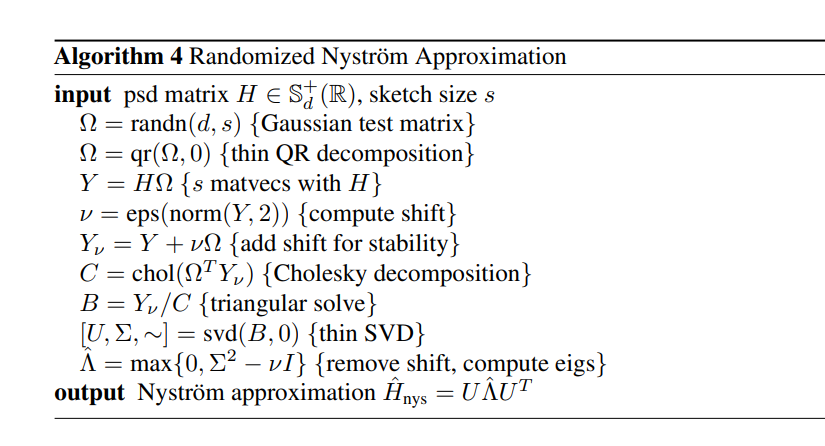

100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


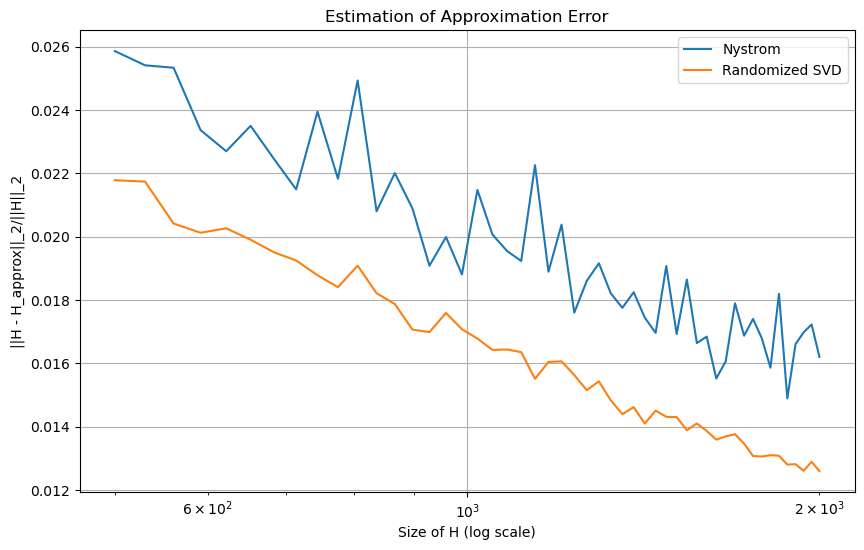

In [7]:
from tqdm import tqdm
sizes = np.linspace(500, 2000, 50)
errors = {
    'Randomized Nystrom Approximation'  : [],
    'Randomized SVD' : []
}
times = {
    'Randomized Nystrom Approximation'  : [],
    'Randomized SVD' : []
}
for size in tqdm(sizes):
    H = make_spd_matrix(int(size))
    ts = time.time()
    U, S = nystrom_approximation(H, s=50)
    tf = time.time()
    H_nys = U @ S @ U.T
    errors['Randomized Nystrom Approximation'].append(np.linalg.norm(H - H_nys)/np.linalg.norm(H))
    times['Randomized Nystrom Approximation'].append(tf - ts)

    ts = time.time()
    U, S, Vt = randomized_svd(H, n_components=50, random_state=42)
    tf = time.time()
    H_rand_svd = U @ np.diag(S) @ Vt
    errors['Randomized SVD'].append(np.linalg.norm(H - H_rand_svd)/np.linalg.norm(H))
    times['Randomized SVD'].append(tf - ts)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, errors['Randomized Nystrom Approximation'], label='Nystrom')
plt.plot(sizes, errors['Randomized SVD'], label='Randomized SVD')
plt.xscale('log') 
plt.xlabel('Size of H (log scale)')
plt.ylabel('||H - H_approx||_2/||H||_2')
plt.title('Estimation of Approximation Error')
plt.legend()
plt.grid(True)
plt.show()

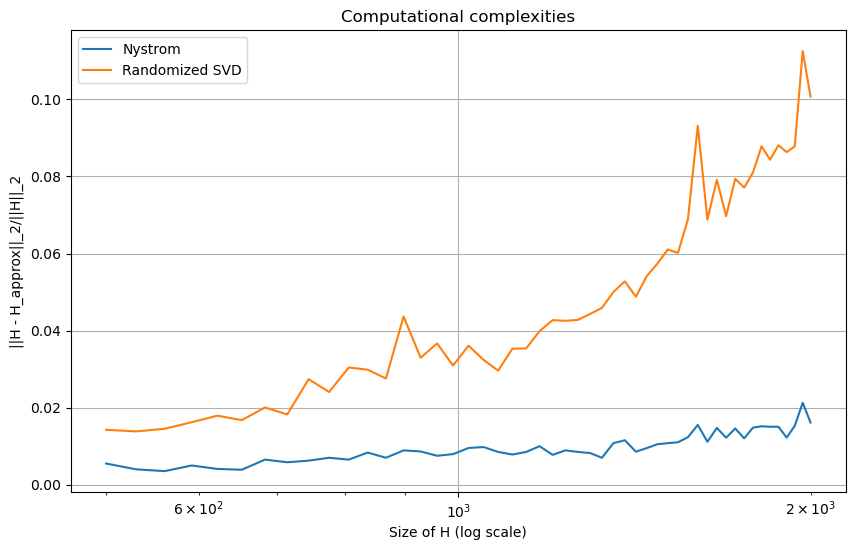

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, times['Randomized Nystrom Approximation'], label='Nystrom')
plt.plot(sizes, times['Randomized SVD'], label='Randomized SVD')
plt.xscale('log') 
plt.xlabel('Size of H (log scale)')
plt.ylabel('||H - H_approx||_2/||H||_2')
plt.title('Computational complexities')
plt.legend()
plt.grid(True)
plt.show()

### Nystrom PCG

Nyström PCG improves on standard CG both in theory and in practice for matrices with a small effective dimension (Frangella et al., 2021), which we now define. Given a symmetric psd matrix $H \in \mathbb{R}^{d \times d}$ and regularization $\rho>0$, the effective dimension of $H$ is
$$
\begin{equation*}
d_{\mathrm{eff}}(\rho)=\operatorname{tr}\left(H(H+\rho I)^{-1}\right) . \tag{8}
\end{equation*}
$$
The effective dimension may be viewed as smoothed count of the eigenvalues of $H$ greater than or equal to $\rho$. We always have $d_{\text {eff }}(\rho) \leq d$, and we expect $d_{\text {eff }}(\rho) \ll d$ whenever $H$ exhibits spectral decay.
In machine learning, most feature matrices naturally exhibit polynomial or exponential spectral decay (Derezinski et al., 2020), thus we expect that $d_{\text {eff }} \ll d$.

Use Nystrom PCG ro find $\hat{x}^{k+1}$ that solves (4) with tolerance $\epsilon^k$

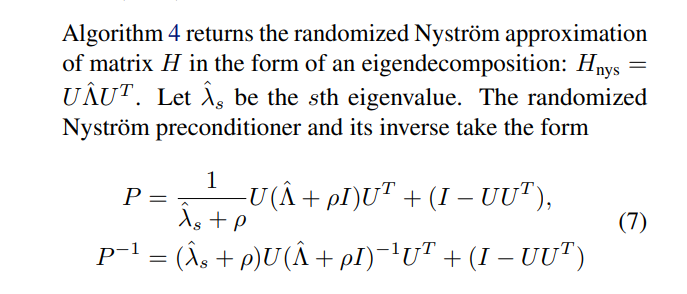

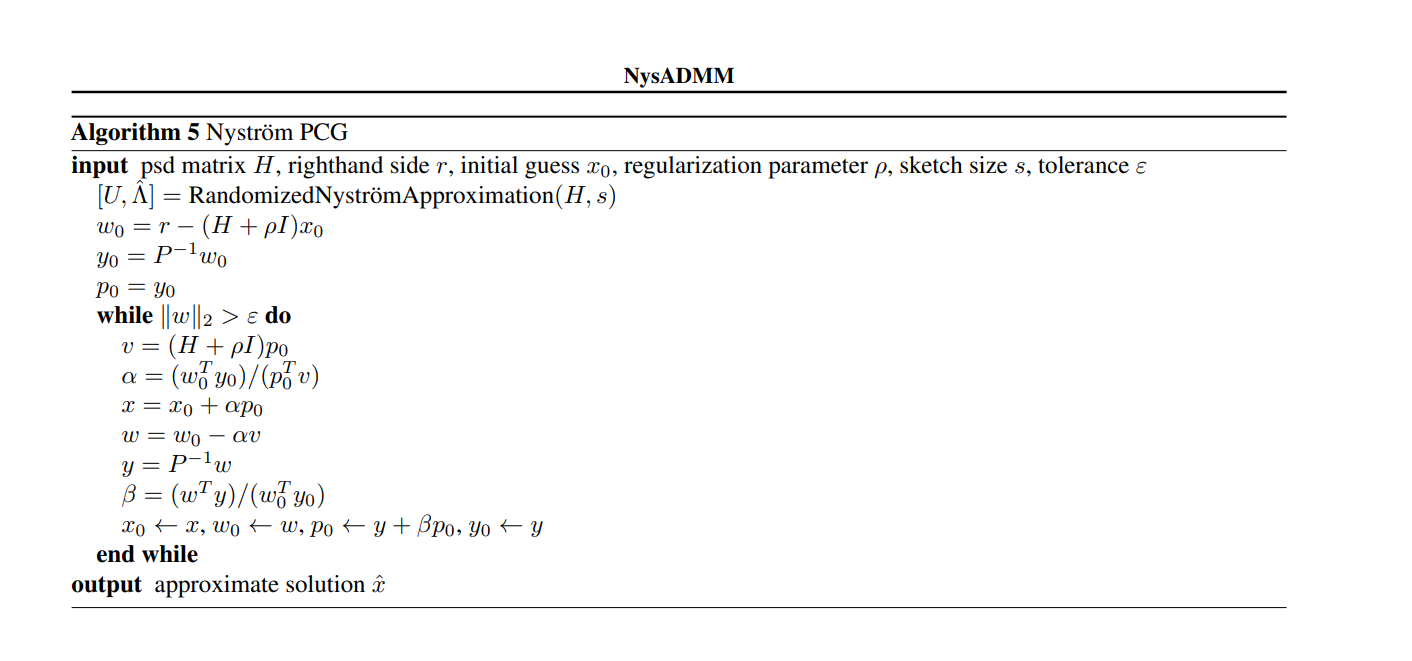

In [9]:
# Test script
def test_nystrom():
    print("\n=== Testing Nystrom PCG Implementation ===")

    # Create a synthetic positive semi-definite matrix H
    np.random.seed(42)
    d = 100  # Dimension of the matrix
    H = np.random.randn(d, d)
    H = H.T @ H  # Symmetric PSD matrix

    # Generate random target vector and initial guess
    r = np.random.randn(d)
    x0 = np.zeros_like(r)

    # Solve using Nystrom PCG
    print("Running Nystrom PCG...")
    U, S = nystrom_approximation(H, s=20)
    x_approx = nystrom_pcg(H, U, S, r, x0, ro=0.01, s=20, epsilon=1e-6)

    # Solve directly for comparison
    print("Solving directly with NumPy...")
    I = np.eye(d)
    exact_solution = solve(H + 0.01 * I, r)

    # Validate results
    error = norm(x_approx - exact_solution) / norm(exact_solution)
    print(f"Relative error of Nystrom PCG: {error:.2e}")
    assert error < 1e-3, "Nystrom PCG did not converge to the expected accuracy."

    print("Test passed!")

# Run the test
test_nystrom()


=== Testing Nystrom PCG Implementation ===
Running Nystrom PCG...
Solving directly with NumPy...
Relative error of Nystrom PCG: 1.00e-10
Test passed!


### NysADMM

In case $\ell(A x ; b)=\frac{1}{2}\|A x-b\|_{2}^{2}$ and $g(x)=\gamma\|x\|_{1}$, we have 
$$
\begin{aligned}
& \nabla l(x) = A^T(Ax-b), & H_l = A^TA,\\
& \nabla g(x) = (\frac{x^1}{|x^1|}, ..., \frac{x^n}{|x^n|})^T,  & H_g = 0
\end{aligned}
$$
$H_l = 2A^TA$ and $H_g = 0$. 

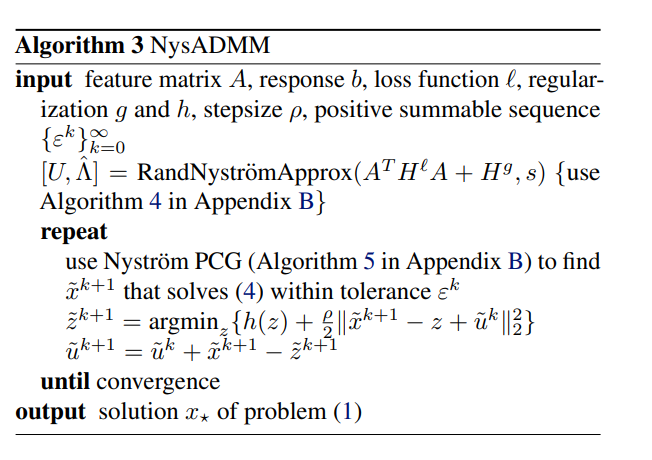

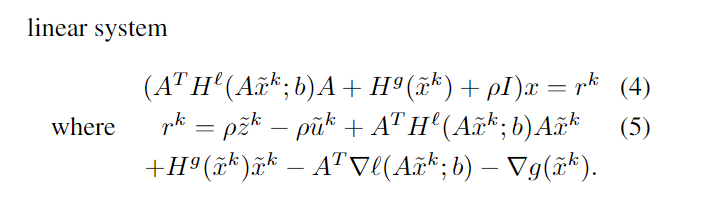